In [1]:
# Reload the notebook automatically
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torchvision
import cv2 
import numpy as np
from pathlib import Path
import sys
from pathlib import Path
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torchvision.models as models
import random 

WORK_DIR = Path(Path.cwd()).parent
sys.path.append(str(WORK_DIR))
from src import ROOT, parse
from src.datasets.transforms import *
from src.utils import *

# Cfg

In [6]:
cfg = parse('/mnt/4TB/aaron/verify_hand_crop_disc/config.cfg')

# Utils

In [15]:
def get_img_crop(uvd_gt, img, pad=50):
    img_size = img.shape

    x_max = int(np.amax(uvd_gt[:,0])) + pad
    x_min = np.maximum(int(np.amin(uvd_gt[:,0])) - pad, 0)
    y_max = int(np.amax(uvd_gt[:,1])) + pad
    y_min = np.maximum(int(np.amin(uvd_gt[:,1])) - pad, 0)
    # ensure bbox is within img bounds
    if y_max > img_size[0]:
        y_max = img_size[0]
    if y_min < 0:
        y_min = 0
    if x_max > img_size[1]:
        x_max = img_size[1]
    if x_min < 0:
        x_min = 0

    width = x_max - x_min
    height = y_max - y_min

#     x_noise = random.uniform(-jitter, jitter)*width
#     y_noise = random.uniform(-jitter, jitter)*height
    x_noise = 0
    y_noise = 0
    y_min_noise = int(y_min + y_noise)
    y_max_noise = int(y_max + y_noise)
    x_min_noise = int(x_min + x_noise)
    x_max_noise = int(x_max + x_noise)

    if y_max_noise > img_size[0]:
        y_max_noise = img_size[0]
    if y_min_noise < 0:
        y_min_noise = 0
    if x_max_noise > img_size[1]:
        x_max_noise = img_size[1]
    if x_min_noise < 0:
        x_min_noise = 0

    hand_crop = img[y_min_noise:y_max_noise, x_min_noise:x_max_noise, :].copy()
    hand_box = np.asarray([(x_min_noise+x_max_noise)/2, (y_min_noise+y_max_noise)/2, width, height])

    if random.random() < 0.3:
        return hand_crop, 1
    
    def get_random_crop():
        rand_x = random.randint(0, img_size[1]-width)
        rand_y = random.randint(0, img_size[0]-height)
        no_hand_crop = img[rand_y:rand_y+height, rand_x:rand_x+width, :].copy()
        no_hand_box = np.asarray([(rand_x+rand_x+width)/2, (rand_y+rand_y+height)/2, width, height])
        return no_hand_crop, no_hand_box

    img_crop, img_box = get_random_crop()
    iou = bbox_iou(hand_box, img_box)
    if iou > 0.3:
        return img_crop, 1
    else:
        return img_crop, 0

# Dataset

In [16]:
class FPHA_Hand_Crop_Dataset(torch.utils.data.Dataset):
    def __init__(self, cfg, split):
        super().__init__()
        split_set = Path(ROOT)/cfg['{}_set'.format(split)]
        xyz = np.loadtxt(split_set)

        split_set = Path(ROOT)/(cfg['{}_set'.format(split)]).replace('xyz', 'img')
        with open(split_set, 'r') as f:
            img_paths = f.read().splitlines()

        self.img_paths = []
        xyz_gt = []
        if cfg['invalid_set']:
            with open(Path(ROOT)/cfg['invalid_set'], 'r') as f:
                invalid_paths = f.readlines()
            invalid_paths = [i.rstrip() for i in invalid_paths]
        else:
            invalid_paths = []

        for i in range(len(img_paths)):
            path = img_paths[i]
            if path not in invalid_paths:
                self.img_paths.append(path)
                xyz_gt.append(xyz[i])

        self.uvd_gt = FPHA.xyz2uvd_color(np.reshape(xyz_gt, (-1, 21, 3)))

        self.img_root = Path(ROOT)/cfg['img_root']
        self.img_rsz = int(cfg['img_rsz'])
        self.ref_depth = int(cfg['ref_depth'])

        if cfg['len'] == 'max':
            self.num_data = len(self.img_paths)
        else:
            self.num_data = int(cfg['len'])

        tfrm = []

        if cfg['aug']:
            if cfg['jitter']:
                jitter = float(cfg['jitter'])
                tfrm.append(ImgTranslate(jitter))
            if cfg['flip']:
                tfrm.append(ImgHFlip())
            if cfg['hsv']:
                hue = float(cfg['hue'])
                sat = float(cfg['sat'])
                val = float(cfg['val'])
                tfrm.append(ImgDistortHSV(hue, sat, val))
            tfrm.append(ImgResize((self.img_rsz)))
            if cfg['rot']:
                rot = float(cfg['rot'])
                tfrm.append(ImgRotate(rot))
        else:
            tfrm.append(ImgResize((self.img_rsz)))

        tfrm.append(ImgToTorch())

        self.transform = torchvision.transforms.Compose(tfrm)

    def __getitem__(self, index):
        img         = cv2.imread(str(self.img_root/self.img_paths[index]))[:, :, ::-1]
        uvd_gt      = self.uvd_gt[index]
        img_crop, is_hand    = get_img_crop(uvd_gt, img)
        uvd_gt[:, 2] /= self.ref_depth

        sample          = {'img': img_crop}
        sample          = self.transform(sample)
        img_crop        = sample['img']

        return img_crop, is_hand

    def __len__(self):
        return self.num_data

In [17]:
train_dataset = FPHA_Hand_Crop_Dataset(cfg, 'train')
kwargs = {
    'batch_size'    : int(cfg['batch_size']),
    'shuffle'       : cfg['shuffle'],
    'num_workers'   : int(cfg['num_workers']),
    'sampler'       : None,
    'pin_memory'    : True
}

train_dataloader = torch.utils.data.DataLoader(train_dataset, **kwargs)

In [18]:
data_load = next(iter(train_dataloader))

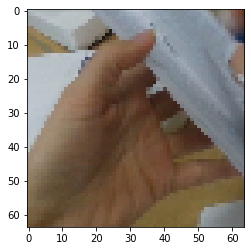

0


In [21]:
idx = 10
img, is_hand = data_load
img = ImgToNumpy()(img)
img = img[idx].copy()
is_hand = is_hand[idx].numpy().copy()
fig, ax = plt.subplots()
ax.imshow(img)
plt.show()
print(is_hand)

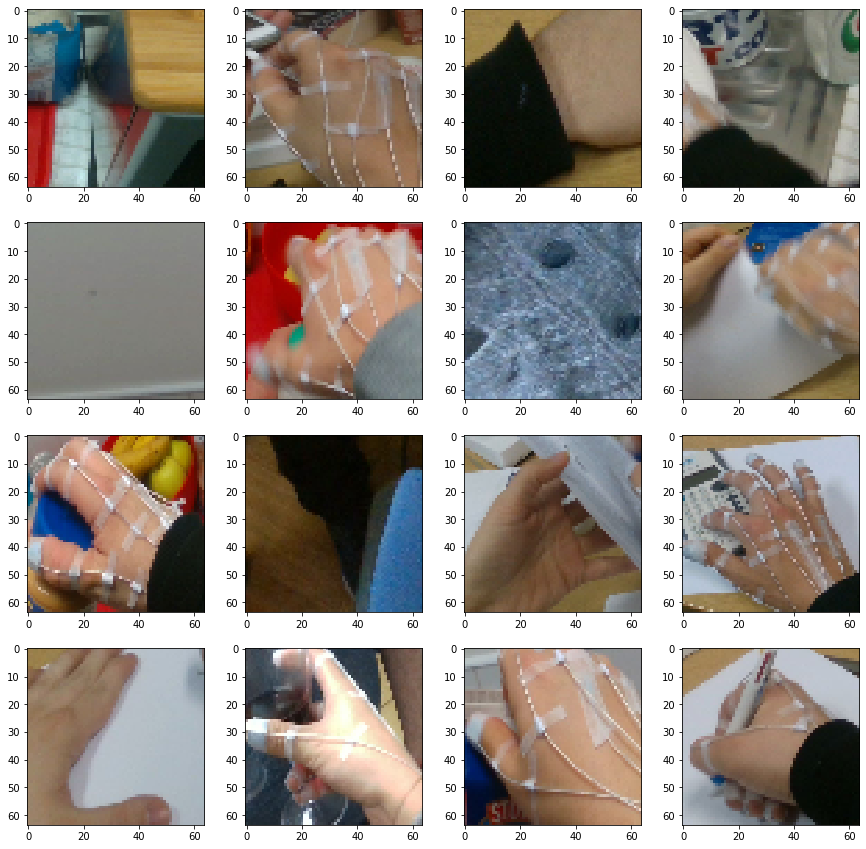

In [20]:
img, is_hand = data_load
img = ImgToNumpy()(img)
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
idx = 0
for i in range(4):
    for j in range(4):
        if idx >= img.shape[0]:
            break
        cur_img = img[idx].copy()
        ax[i, j].imshow(cur_img)
        idx += 1
plt.show()

# Discriminator

In [ ]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(3, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = 64 // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

In [ ]:
model = Discriminator().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
bceloss = torch.nn.BCELoss()

# Train

In [ ]:
from livelossplot import PlotLosses
from tqdm import tqdm

liveloss = PlotLosses()
max_epoch = 50
model = model.train()
best_loss = 1000
for epoch in range(max_epoch):
    logs = {}
    running_loss = 0.0
    for img_crop, is_hand in tqdm(train_dataloader):
        img_crop = img_crop.cuda()
        is_hand = is_hand.type(torch.FloatTensor).cuda()
        
        out = model(img_crop)
        out = out.squeeze()
        loss = bceloss(out, is_hand)
        
        running_loss += loss.item()
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    running_loss /= len(train_dataloader)
    logs['loss'] = running_loss
    state = {'epoch': epoch, 
             'model_state_dict': model.state_dict(), 
             'optimizer_state_dict': optimizer.state_dict()}
    if running_loss < best_loss:
        best_loss = running_loss
        torch.save(state, Path(ROOT)/'mlcv-exp'/'data'/'weights'/'model_verify_hand_disc_best.state')
    torch.save(state, Path(ROOT)/'mlcv-exp'/'data'/'weights'/'model_verify_hand_disc_{}.state'.format(epoch))
    liveloss.update(logs)
    liveloss.draw()